# 1. Load libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
import calendar

In [ ]:

# Read data
excel_file = r"C:\Users\Dell\Documents\(1) Neu\Big data\Cleaned_Insurance_Claims_Data.xlsx"
# Read individual sheets
products_df = pd.read_excel(excel_file, sheet_name='Products')
claims_payments_df = pd.read_excel(excel_file, sheet_name='Claims Payments')
regions_df = pd.read_excel(excel_file, sheet_name='Regions')
state_regions_df = pd.read_excel(excel_file, sheet_name='State Regions')
policies_df = pd.read_excel(excel_file, sheet_name='Policies')
participants_df = pd.read_excel(excel_file, sheet_name='Participants')
brokers_df = pd.read_excel(excel_file, sheet_name='Brokers')
products_df = pd.read_excel(excel_file, sheet_name='Products')
claims_announcements_df = pd.read_excel(excel_file, sheet_name='Claims Announcements')
claims_reserves_df = pd.read_excel(excel_file, sheet_name='Claims Reserves')

# 2. Income analysis

## 2.1 Premium income by product type

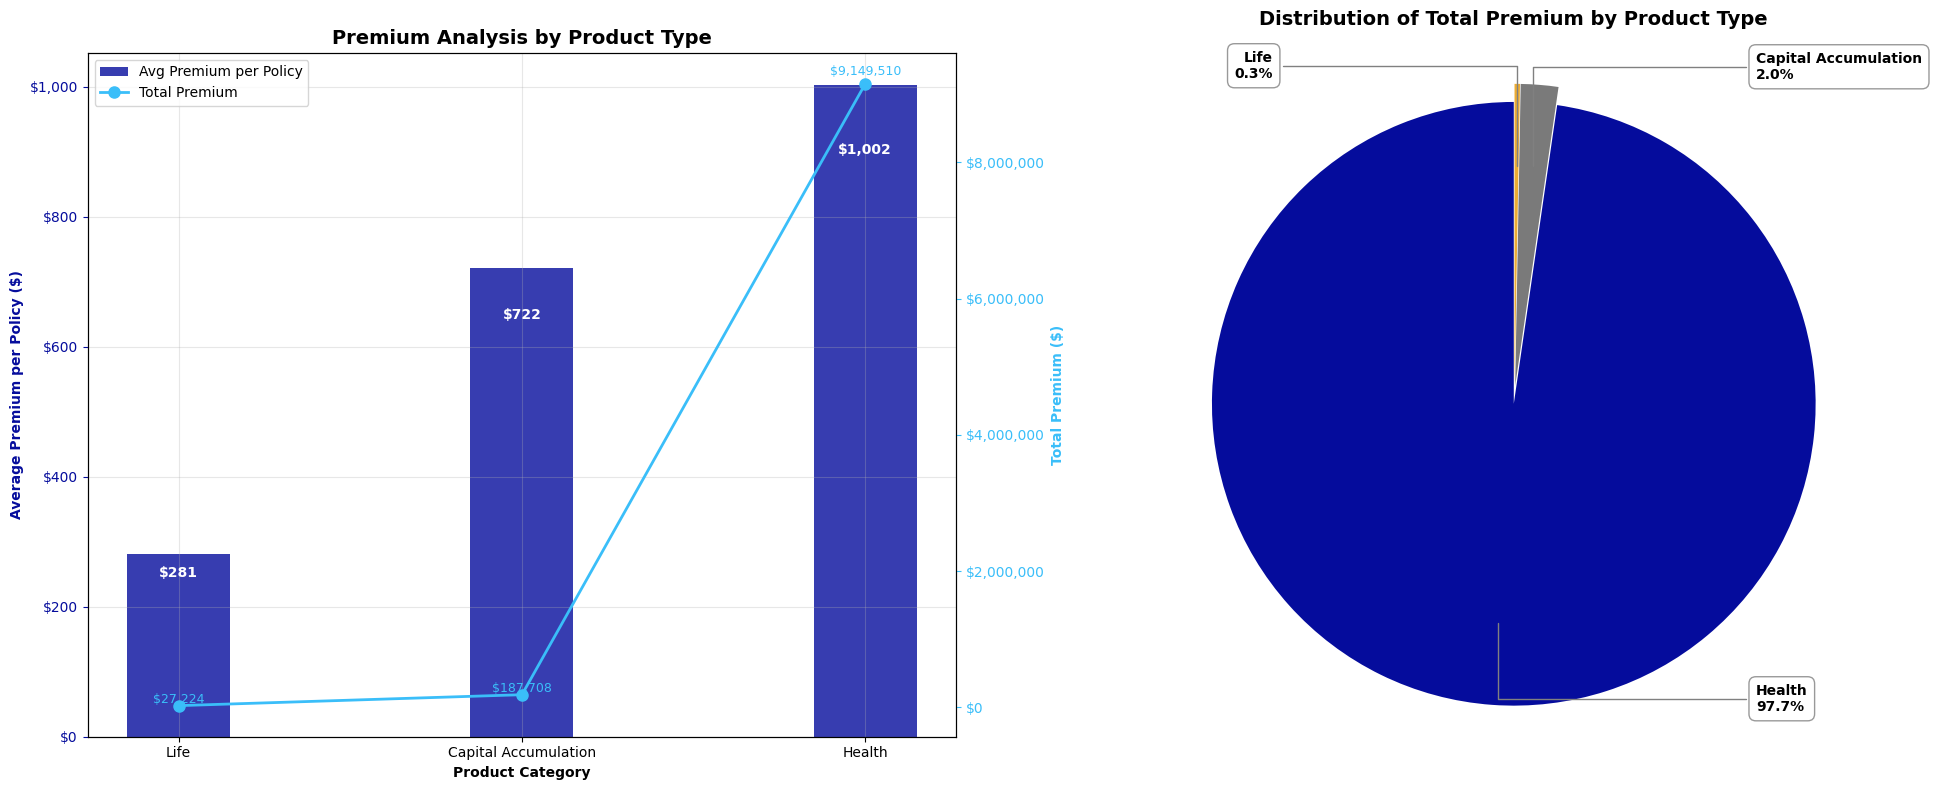


Product Premium Distribution:
        ProductCategory  TotalPremium  Percentage
1                Health    9149509.85       97.70
0  Capital Accumulation     187707.84        2.00
2                  Life      27223.64        0.29


In [3]:
# Merge policies with products for product names
premium_by_product = pd.merge(policies_df, products_df, on='ProductID', how='left')
# Group by ProductCategory only to avoid duplicates
product_premium = premium_by_product.groupby('ProductCategory')['AnnualizedPolicyPremium'].sum().reset_index()

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(20, 8))

# First subplot - Premium Analysis
ax1 = plt.subplot(1, 2, 1)

# Calculate premium ratio by product category
product_premium_ratio = (policies_df.merge(products_df[['ProductID', 'ProductCategory']], on='ProductID')
    .groupby('ProductCategory')
    .agg({
        'PolicyID': 'count',
        'AnnualizedPolicyPremium': ['sum', 'mean']
    })
    .reset_index())

# Flatten column names and sort
product_premium_ratio.columns = ['ProductCategory', 'PolicyCount', 'TotalPremium', 'AvgPremium']
product_premium_ratio = product_premium_ratio.sort_values('AvgPremium')

# Define colors
colors = ['#050C9C', '#7A7A7A', '#3ABEF9', '#ECAC34']

# Create bars
bars = ax1.bar(product_premium_ratio['ProductCategory'], 
               product_premium_ratio['AvgPremium'],
               width=0.3,
               color=colors[0],
               alpha=0.8,
               label='Avg Premium per Policy')

# Create secondary axis and line
ax1_twin = ax1.twinx()
line = ax1_twin.plot(product_premium_ratio['ProductCategory'], 
                     product_premium_ratio['TotalPremium'], 
                     color=colors[2], 
                     marker='o',
                     linewidth=2,
                     label='Total Premium',
                     markersize=8)

# Customize first subplot axes
ax1.set_title('Premium Analysis by Product Type', fontsize=14, weight='bold')
ax1.set_xlabel('Product Category', weight='bold')
ax1.set_ylabel('Average Premium per Policy ($)', color=colors[0], weight='bold')
ax1.tick_params(axis='x')
ax1.tick_params(axis='y', colors=colors[0])
ax1.grid(True, alpha=0.3)

ax1_twin.set_ylabel('Total Premium ($)', color=colors[2], weight='bold')
ax1_twin.tick_params(axis='y', colors=colors[2])

# Add custom formatter for comma-separated numbers
def format_func(value, tick_number):
    return f'${value:,.0f}'

ax1.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax1_twin.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

# Add value labels for first subplot
for i, rect in enumerate(bars):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., height - (height * 0.1),
             f'${product_premium_ratio["AvgPremium"].iloc[i]:,.0f}',
             ha='center', va='center', color='white', fontsize=10, weight='bold')
    
    ax1_twin.text(i, product_premium_ratio['TotalPremium'].iloc[i] + (product_premium_ratio['TotalPremium'].iloc[i] * 0.01),
             f'${product_premium_ratio["TotalPremium"].iloc[i]:,.0f}',
             ha='center', va='bottom', color=colors[2], fontsize=9)

# Combine legends for first subplot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
          loc='upper left')  # Changed legend position

# Second subplot - Pie Chart
ax2 = plt.subplot(1, 2, 2)

# Calculate total premium percentage by product
product_premium_pct = (product_premium_ratio
    .assign(Percentage=lambda x: (x['TotalPremium'] / x['TotalPremium'].sum()) * 100)
    .sort_values('Percentage', ascending=False))

# Create pie chart with modified settings
wedges, texts, autotexts = ax2.pie(product_premium_pct['Percentage'],
                                  labels=[''] * len(product_premium_pct),  # Empty labels for now
                                  colors=[colors[0], colors[1], colors[3]],
                                  explode=[0.03, 0.03, 0.03],
                                  autopct='',  # Remove default percentage
                                  startangle=90,
                                  pctdistance=0.75)

# Add callout lines and labels
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    
    # Set position based on category
    if product_premium_pct["ProductCategory"].iloc[i] == 'Life':
        text_x = -0.8 # Left side, moved further
        ha = 'right'
    else:
        text_x = 0.8  # Right side, moved further
        ha = 'left'
    
    # Calculate y position to avoid overlap
    text_y = y * 1.05
    
    # Create annotation with percentage and category
    ax2.annotate(f'{product_premium_pct["ProductCategory"].iloc[i]}\n{product_premium_pct["Percentage"].iloc[i]:.1f}%',
                xy=(x*0.75, y*0.75),  # Point on the pie, moved further from center
                xytext=(text_x, text_y),  # External point, moved further out
                ha=ha,
                fontsize=10,
                weight='bold',
                bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                arrowprops=dict(
                    arrowstyle='-',
                    connectionstyle='angle,angleA=0,angleB=90',
                    color='gray',
                    linestyle='-'
                ))

# Ensure circular shape
ax2.axis('equal')

# Add title
ax2.set_title('Distribution of Total Premium by Product Type', 
              fontsize=14, weight='bold', pad=20)

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nProduct Premium Distribution:")
summary = product_premium_pct[['ProductCategory', 'TotalPremium', 'Percentage']].round(2)
print(summary)

### Key Findings
Health Insurance is our cash cow. It brings in 97.7% of premium income, averaging $1,002 per policy.

Capital Accumulation contributes just 2%, and Life Insurance only 0.3%, with the lowest average premium at $281.

This shows a strong reliance on one product. While it highlights our strength in Health Insurance, it also signals a concentration risk if market conditions change.

#### Product-wise Premium Structure
1. **Health Insurance**
   - Highest average premium per policy: $1,002
   - Dominates total premium collection
   - Represents 97.7% of total premium income
   - Suggests health insurance is the primary revenue driver

2. **Capital Accumulation**
   - Medium-range average premium: $722
   - Contributes 2.0% to total premium income
   - Indicates a niche product with moderate pricing

3. **Life Insurance**
   - Lowest average premium per policy: $281
   - Minimal contribution to total revenue (0.3%)
   - Possibly an entry-level or supplementary product

#### Business Implications
1. **Revenue Concentration**
   - Heavy dependence on health insurance products
   - Potential business risk due to lack of diversification
   - Strong market position in health insurance sector

2. **Pricing Strategy**
   - Clear premium tier structure across products
   - Health insurance commands premium pricing
   - Life insurance positioned as affordable option

3. **Business Focus**
   - Clear specialization in health insurance
   - Other products might serve specific market segments
   - Opportunity for growth in non-health segments

#### Recommendations
1. Consider diversifying product portfolio to reduce dependency on health insurance
2. Evaluate pricing strategy for life insurance to improve revenue contribution
3. Investigate potential for expanding capital accumulation products
4. Monitor market competition in health insurance due to high revenue dependency

## 2.2 Monthly Premium analysis

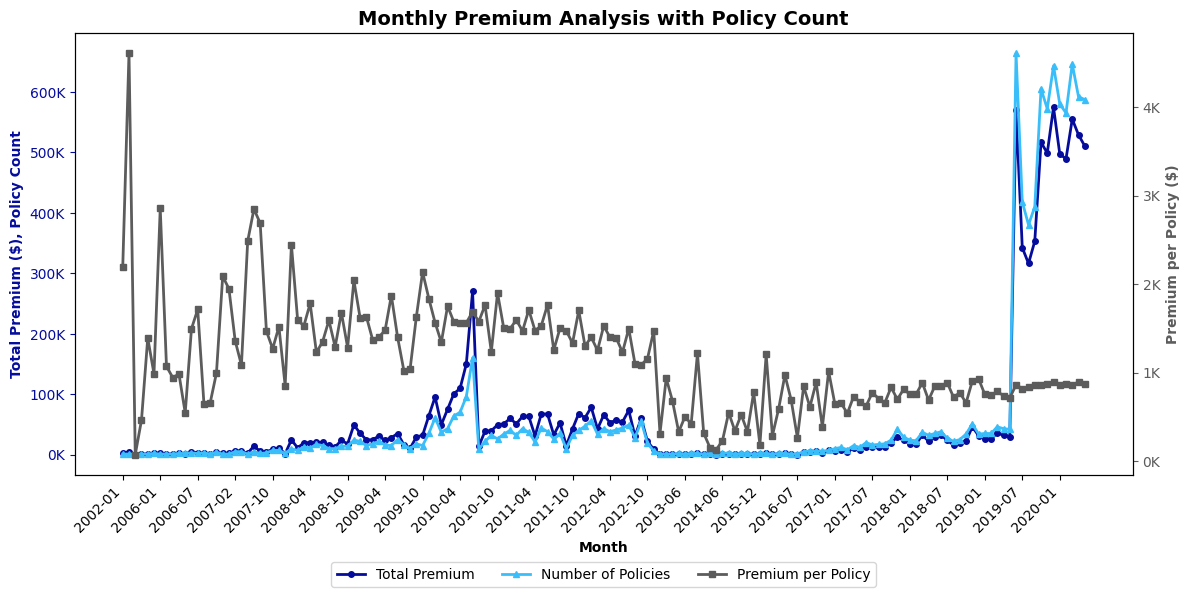


Recent Period Analysis (2019-2020):
      TotalPremium  PolicyCount  PremiumPerPolicy
mean     347203.11       403.71            827.61
max      574334.70       664.00            893.38


In [26]:
def calculate_premium_metrics(data, date_column='PolicyStartDate'):
    monthly_metrics = (data
        .assign(Month=pd.to_datetime(data[date_column]).dt.strftime('%Y-%m'))
        .groupby('Month')
        .agg({
            'AnnualizedPolicyPremium': 'sum',
            'PolicyID': 'count'
        })
        .reset_index()
        .rename(columns={
            'AnnualizedPolicyPremium': 'TotalPremium',
            'PolicyID': 'PolicyCount'
        }))
    
    monthly_metrics['PremiumPerPolicy'] = monthly_metrics['TotalPremium'] / monthly_metrics['PolicyCount']
    return monthly_metrics

monthly_metrics = calculate_premium_metrics(policies_df)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
ax_twin = ax.twinx()

# Plot all metrics
lines = [
    ax.plot(monthly_metrics['Month'], 
            monthly_metrics['TotalPremium'] / 1000,
            color='#050C9C', linewidth=2, marker='o', 
            markersize=4, label='Total Premium'),
            
    ax.plot(monthly_metrics['Month'],
            monthly_metrics['PolicyCount'],
            color='#3ABEF9', linewidth=2, marker='^',
            markersize=4, label='Number of Policies'),
            
    ax_twin.plot(monthly_metrics['Month'],
                 monthly_metrics['PremiumPerPolicy'] / 1000,
                 color='#5C5C5C', linewidth=2, marker='s',
                 markersize=4, label='Premium per Policy')
]

# Customize plot
ax.set_title('Monthly Premium Analysis with Policy Count', fontsize=14, weight='bold')
ax.set_xlabel('Month', weight='bold')
ax.set_ylabel('Total Premium ($), Policy Count', color='#050C9C', weight='bold')
ax_twin.set_ylabel('Premium per Policy ($)', color='#5C5C5C', weight='bold')

# Format both axes
def format_func(value, tick_number):
    return f'{value:,.0f}K'

for axis in [ax, ax_twin]:
    axis.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    
ax.tick_params(axis='y', colors='#050C9C')
ax_twin.tick_params(axis='y', colors='#5C5C5C')

# Set x-axis labels
ax.set_xticks(range(0, len(monthly_metrics), 6))
ax.set_xticklabels(monthly_metrics['Month'][::6], rotation=45, ha='right')

# Combine legends
ax.legend(sum(lines, []), [l.get_label() for l in sum(lines, [])],
         loc='lower center', bbox_to_anchor=(0.5, -0.27), ncol=3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

# Print summary
print("\nRecent Period Analysis (2019-2020):")
recent_metrics = monthly_metrics[monthly_metrics['Month'] >= '2019-01'].agg({
    'TotalPremium': ['mean', 'max'],
    'PolicyCount': ['mean', 'max'],
    'PremiumPerPolicy': ['mean', 'max']
}).round(2)
print(recent_metrics)

### Key findings
**1. Recent growth spike (2019-2020)**
- Dramatic increase in both total premium and number of policies
- Total premium reached peaks of around 500K-600K
- Number of policies increased proportionally
- Premium per policy remained relatively stable (~1K)
- Suggests successful business expansion through volume rather than price increases

**2. Historical patterns (2002-2018)**
- Early volatility in premium per policy (2002-2007)
  * Highest spike around 4.5K per policy in 2002
  * Gradually stabilized to around 1K per policy
- Stable period (2008-2018)
  * Total premium mostly under 100K
  * Consistent policy count
  * One notable spike around 2010-2011 (~270K in total premium)

**3. Business model evolution**
- Early years (2002-2007): High premium per policy, lower volume
- Middle period (2008-2018): Stabilized premium per policy, moderate volume
- Recent years (2019-2020): Same premium per policy, much higher volume

**4. Key business implications**
- Successful scaling strategy:
   + Growth through volume increase rather than price increases
   + Maintained pricing stability while expanding customer base
   
- Risk considerations:
   + Heavy dependence on volume for revenue growth
   + Need to ensure operational capacity matches growth
   + Important to monitor claim rates with increased policy volume

# 3. Expenses analysis (Claims payments)

## 3.1 Claims payments by product type

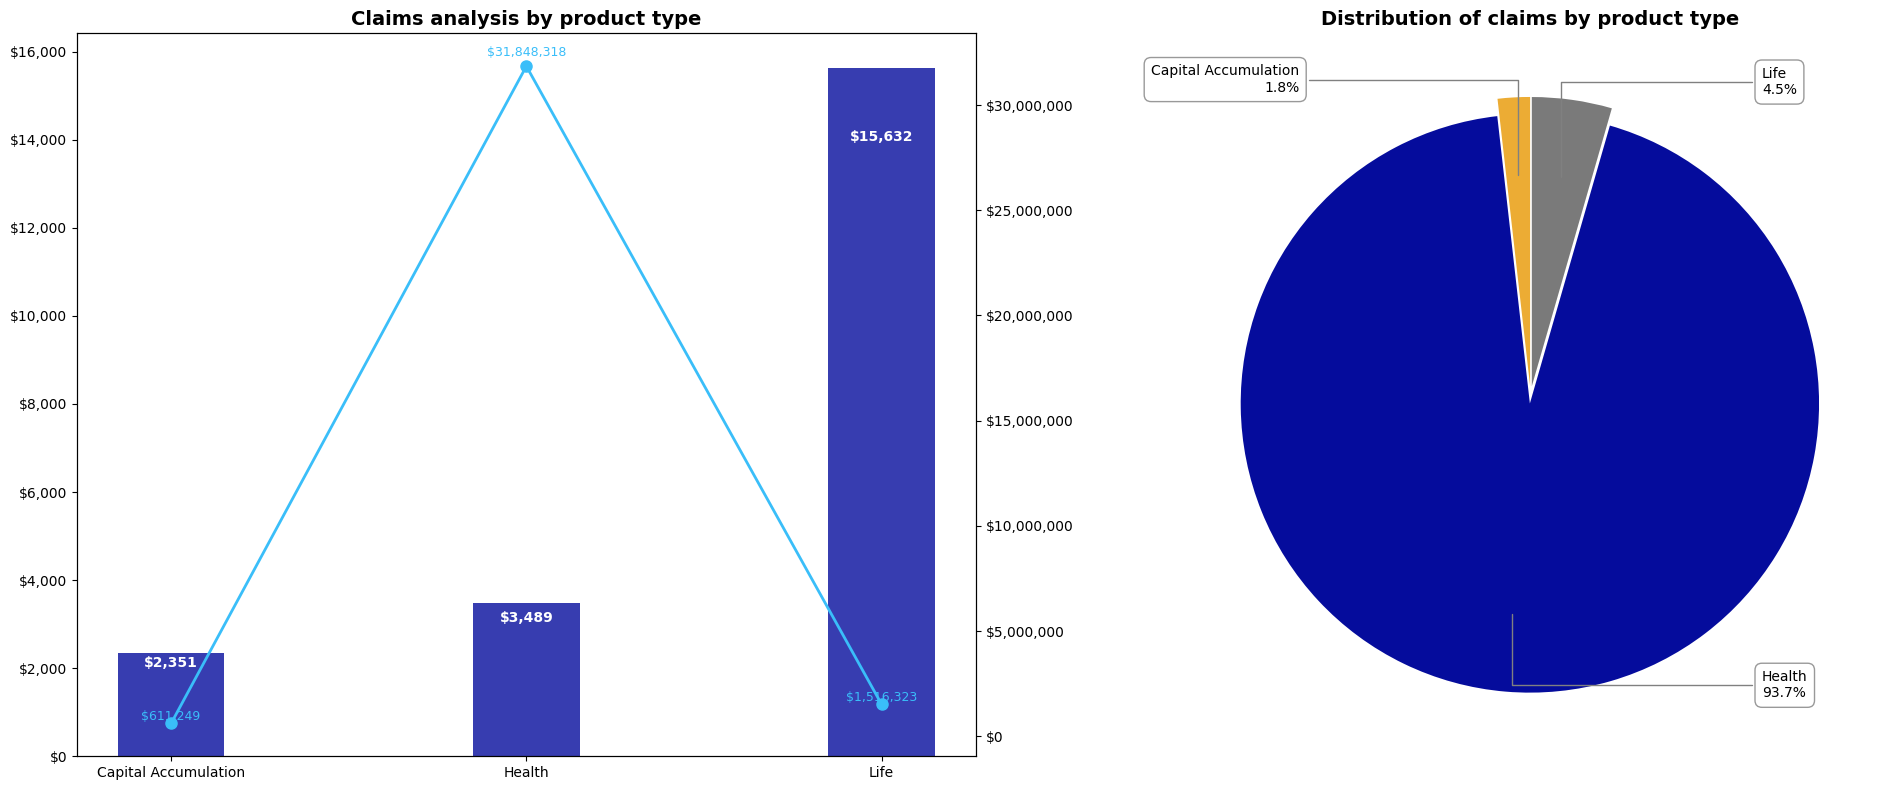

In [33]:
def calculate_claims_metrics(claims_df, policies_df, products_df):
    # Calculate claims metrics in one go
    claims_analysis = (claims_df
        .merge(products_df[['ProductID', 'ProductCategory']], on='ProductID')
        .groupby('ProductCategory')
        .agg({'PaymentAmount': 'sum', 'ClaimID': 'count'})
        .reset_index())
    
    # Add policy counts and calculate averages
    policy_counts = (policies_df
        .merge(products_df[['ProductID', 'ProductCategory']], on='ProductID')
        .groupby('ProductCategory')
        .size()
        .reset_index(name='PolicyCount'))
    
    return (claims_analysis
        .merge(policy_counts, on='ProductCategory')
        .assign(
            AvgClaimPerPolicy=lambda x: x['PaymentAmount'] / x['PolicyCount'],
            Percentage=lambda x: (x['PaymentAmount'] / x['PaymentAmount'].sum()) * 100
        )
        .sort_values('AvgClaimPerPolicy'))

def plot_claims_analysis(claims_analysis, colors=['#050C9C', '#7A7A7A', '#3ABEF9', '#ECAC34']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    ax1_twin = ax1.twinx()
    
    # Plot bar and line chart
    bars = ax1.bar(claims_analysis['ProductCategory'], 
                   claims_analysis['AvgClaimPerPolicy'],
                   width=0.3, color=colors[0], alpha=0.8,
                   label='Avg Claim per Policy')
    
    line = ax1_twin.plot(claims_analysis['ProductCategory'], 
                        claims_analysis['PaymentAmount'],
                        color=colors[2], marker='o', linewidth=2,
                        label='Total Claims', markersize=8)
    
    # Add value labels and customize axes
    for i, rect in enumerate(bars):
        height = rect.get_height()
        ax1.text(rect.get_x() + rect.get_width()/2., height - (height * 0.1),
                f'${claims_analysis["AvgClaimPerPolicy"].iloc[i]:,.0f}',
                ha='center', va='center', color='white', fontsize=10, weight='bold')
        
        ax1_twin.text(i, claims_analysis['PaymentAmount'].iloc[i] * 1.01,
                f'${claims_analysis["PaymentAmount"].iloc[i]:,.0f}',
                ha='center', va='bottom', color=colors[2], fontsize=9)
    
    # Customize axes
    for ax in [ax1, ax1_twin]:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Plot pie chart - fix the unpacking
    wedges, texts = ax2.pie(claims_analysis['Percentage'],
                           labels=[''] * len(claims_analysis),
                           colors=[colors[3], colors[0], colors[1]],
                           explode=[0.03] * len(claims_analysis),
                           startangle=90)
    
    # Add annotations
    for i, wedge in enumerate(wedges):
        ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        
        text_x = -0.8 if claims_analysis["ProductCategory"].iloc[i] == 'Capital Accumulation' else 0.8
        ax2.annotate(f'{claims_analysis["ProductCategory"].iloc[i]}\n{claims_analysis["Percentage"].iloc[i]:.1f}%',
                    xy=(x*0.75, y*0.75), xytext=(text_x, y * 1.05),
                    ha='right' if text_x < 0 else 'left',
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                    arrowprops=dict(arrowstyle='-', connectionstyle='angle,angleA=0,angleB=90', color='gray'))
    
    # Set titles and adjust layout
    ax1.set_title('Claims analysis by product type', fontsize=14, weight='bold')
    ax2.set_title('Distribution of claims by product type', fontsize=14, weight='bold')
    plt.tight_layout()
    
    return fig

# Calculate metrics and create plots
claims_analysis = calculate_claims_metrics(claims_payments_df, policies_df, products_df)
plot_claims_analysis(claims_analysis)
plt.show()

### Distribution of claims by product
- Health insurance dominates claims payments (93.7%)
- Life insurance accounts for 4.5% of total claims
- Capital accumulation has minimal claims (1.8%)
- Suggests health insurance is the main cost driver

### Claims per policy analysis
- Life insurance: highest average claim per policy ($15,632)
- Health insurance: moderate average claim ($3,489)
- Capital accumulation: lowest average claim ($2,151)

### Claims patterns by product
1. Health insurance:
   - High total claims but moderate per-policy cost
   - High frequency, medium-value claims pattern
   - Matches typical health insurance business model

2. Life insurance:
   - Low total claims but highest per-policy amount
   - Low frequency, high-value claims pattern
   - Typical for life insurance products

3. Capital accumulation:
   - Both low total and per-policy claims
   - Most financially efficient product
   - Suggests good risk management

### Business implications
1. Cost management priorities:
   - Focus on health insurance claims efficiency
   - Monitor life insurance large claim risks
   - Maintain capital accumulation performance

2. Risk assessment:
   - Health insurance needs volume management
   - Life insurance needs high-value claim management
   - Capital accumulation shows good risk-reward balance

## 3.2 Geographical distribution of claims

### Plotting

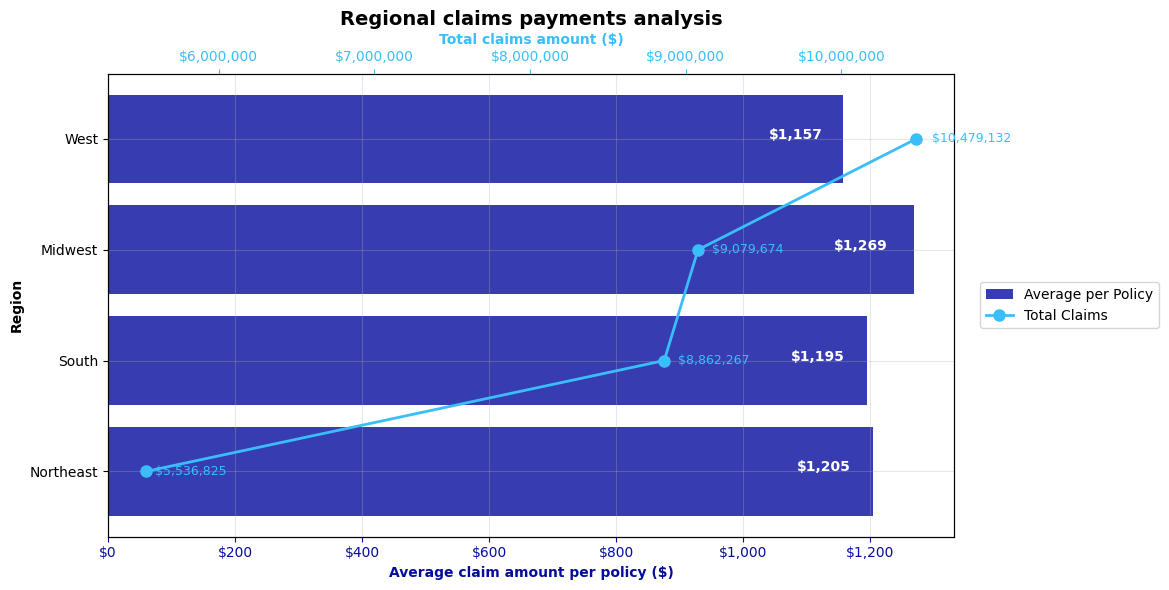


Regional claims summary:
          PaymentAmount                ClaimID
                    sum count     mean   count
Region                                        
Midwest      9079674.01  7154  1269.17    7154
Northeast    5536824.76  4596  1204.71    4596
South        8862266.80  7417  1194.86    7417
West        10479132.20  9059  1156.76    9059


In [68]:
def calculate_regional_metrics(claims_df, participants_df, regions_df, state_regions_df, policies_df):
    # Create bridge from Claims to Regions
    claims_regional = (claims_df
        .merge(participants_df[['ParticipantID', 'RegionID']], 
               left_on='InsuredID', right_on='ParticipantID')
        .merge(regions_df[['id', 'state_code']], 
               left_on='RegionID', right_on='id')
        .merge(state_regions_df[['State Code', 'Region']], 
               left_on='state_code', right_on='State Code'))
    
    # Calculate metrics
    regional_metrics = claims_regional.groupby('Region').agg({
        'PaymentAmount': ['sum', 'count', 'mean'],
        'ClaimID': 'count'
    }).round(2)
    
    return claims_regional, regional_metrics

def plot_regional_analysis(regional_metrics, colors=['#050C9C', '#3572EF', '#3ABEF9', '#A7E6FF']):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twiny()
    
    # Get total claims and average per region
    total_claims = regional_metrics['PaymentAmount']['sum'].sort_values()
    avg_claims = regional_metrics['PaymentAmount']['mean'].reindex(total_claims.index)
    
    # Plot bars and line
    bars = ax1.barh(avg_claims.index, avg_claims.values, 
                    color=colors[0], alpha=0.8, label='Average per Policy')
    
    ax2.plot(total_claims.values, range(len(total_claims)), 
             color=colors[2], marker='o', linewidth=2, 
             label='Total Claims', markersize=8)
    
    # Add value labels
    for i, (avg, total) in enumerate(zip(avg_claims, total_claims)):
        ax1.text(avg * 0.9, i, f'${avg:,.0f}', 
                 color='white', fontsize=10, weight='bold')
        ax2.text(total * 1.01, i, f'${total:,.0f}', 
                 color=colors[2], fontsize=9, va='center')
    
    # Customize axes
    def format_currency(x, p):
        return f'${x:,.0f}'
    
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(format_currency))
    
    ax1.set_title('Regional claims payments analysis', fontsize=14, weight='bold')
    ax1.set_xlabel('Average claim amount per policy ($)', color=colors[0], weight='bold')
    ax1.set_ylabel('Region', weight='bold')
    ax2.set_xlabel('Total claims amount ($)', color=colors[2], weight='bold')
    
    ax1.tick_params(axis='x', colors=colors[0])
    ax2.tick_params(axis='x', colors=colors[2])
    ax1.grid(True, alpha=0.3)
    
    # Add legend
    lines = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
    labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
    ax1.legend(lines, labels, loc='center right', bbox_to_anchor=(1.25, 0.5))
    
    plt.tight_layout()
    return fig

# Calculate metrics and create visualization
claims_regional, regional_metrics = calculate_regional_metrics(
    claims_payments_df, participants_df, regions_df, state_regions_df, policies_df
)
plot_regional_analysis(regional_metrics)
plt.show()

# Print summary
print("\nRegional claims summary:")
print(regional_metrics)

### Key findings
**Total claims distribution**
- West region: highest total claims (~$10.5M)
- Midwest: second highest (~$9.1M)
- South: similar to Midwest (~$8.9M)
- Northeast: significantly lower (~$6.5M)

**Average claim per policy**
- Midwest: highest average ($1,269 per policy)
- Northeast: lowest average ($1,205 per policy)
- Small variation in averages:
  * Range is only $64 ($1,269 - $1,205)
  * Suggests consistent pricing across regions

**Regional patterns**
1. West region:
   - Highest total claims but not highest average
   - Indicates large policy volume rather than high individual claims

2. Midwest region:
   - High total claims and highest average
   - Suggests both volume and higher individual claim values

3. South region:
   - Moderate in both total and average claims
   - Balanced distribution of claims

4. Northeast region:
   - Lowest in both metrics
   - Potential opportunity for market expansion

**Business implications**
- Regional risk assessment appears well-balanced
- Pricing strategy is consistent across regions
- Northeast market might need growth initiatives
- West region requires strong operational capacity

## 3.3 Claims payments calendar heatmap

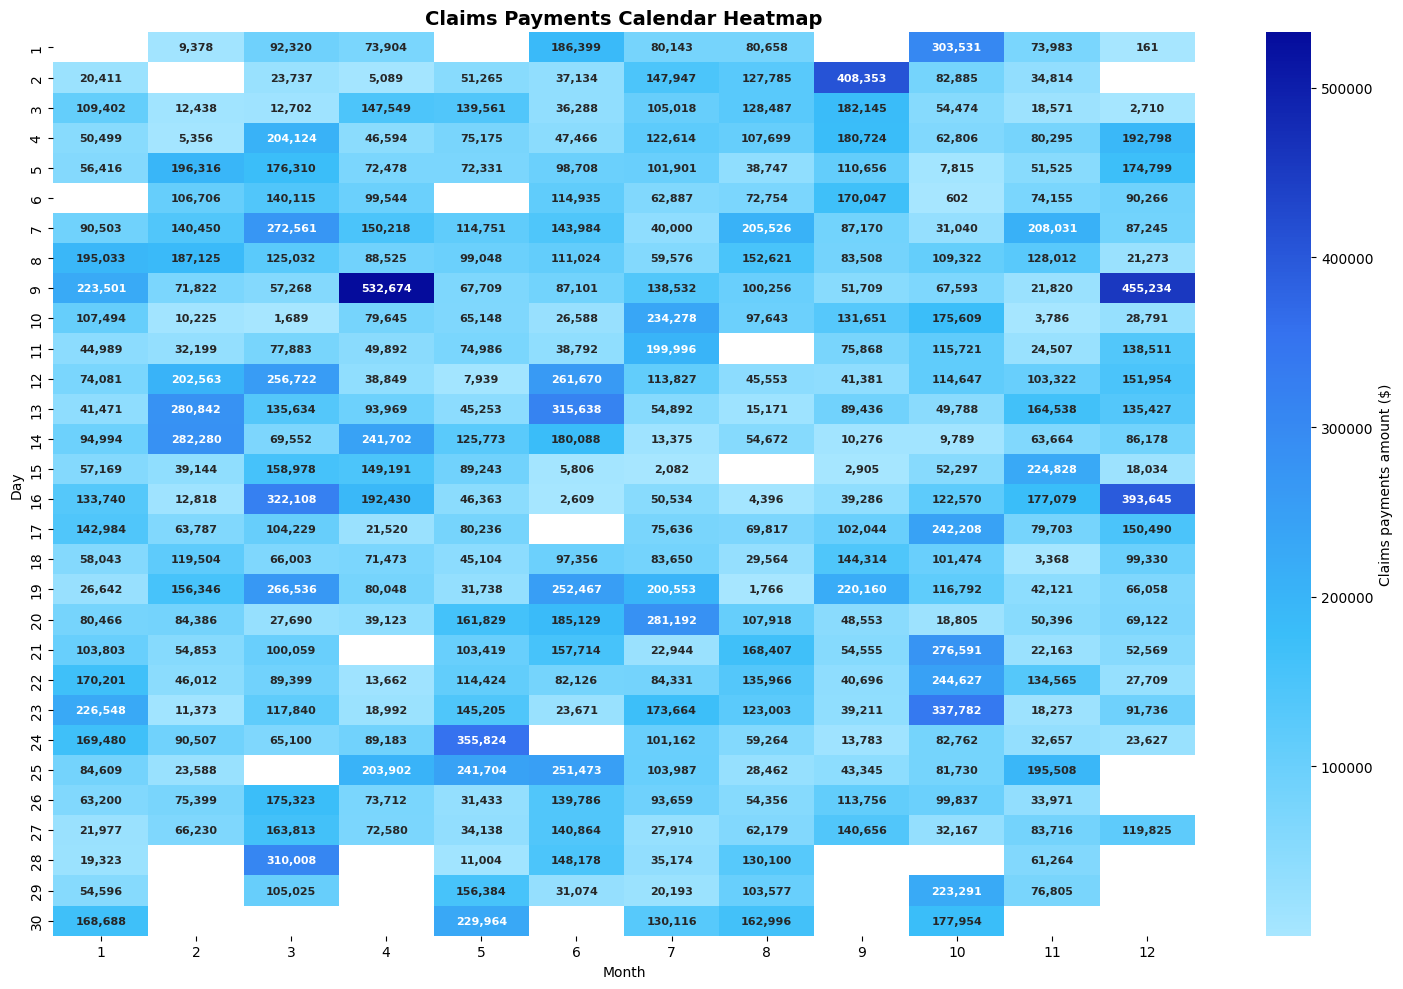

In [39]:
# Prepare daily claims data
claims_payments_df['PaymentDate'] = pd.to_datetime(claims_payments_df['PaymentDate'])
daily_claims = claims_payments_df.groupby('PaymentDate')['PaymentAmount'].sum().reset_index()

# Create calendar heatmap
daily_claims['Year'] = daily_claims['PaymentDate'].dt.year
daily_claims['Month'] = daily_claims['PaymentDate'].dt.month
daily_claims['Day'] = daily_claims['PaymentDate'].dt.day

pivot_table = daily_claims.pivot_table(index='Day', 
                                     columns='Month', 
                                     values='PaymentAmount', 
                                     aggfunc='sum')

# Create custom colormap using our color scheme
colors = ['#A7E6FF', '#3ABEF9', '#3572EF', '#050C9C']
custom_cmap = LinearSegmentedColormap.from_list('custom_blues', colors)

plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, 
            cmap=custom_cmap,
            annot=True, 
            fmt=',.0f',
            cbar_kws={'label': 'Claims payments amount ($)'},
            annot_kws={'size': 8, 'weight': 'bold'})

plt.title('Claims Payments Calendar Heatmap', fontsize=14, weight='bold')
plt.xlabel('Month')
plt.ylabel('Day')
plt.tight_layout()
plt.show()

**1. Monthly patterns (x-axis)**
- Peak payments in September (month 9)
  * Multiple days with payments over $300K
  * Highest single-day payment ~$455K on day 9
- Strong activity in October (month 10)
- Relatively lower payments in early months (January-March)

**2. Daily patterns (y-axis)**
- High payment activity between days 15-20 across months
- Notable patterns:
  * Day 9: Consistently high payments
  * Days 28-31: Generally lower payments
  * Days 1-5: Moderate payment levels

**3. Seasonal trends**
- Q3 (months 7-9): Highest payment activity
- Q1 (months 1-3): Lower payment volumes
- Q4 (months 10-12): Moderate to high activity
- Q2 (months 4-6): Consistent moderate payments

**4. Business implications**
- Payment processing:
   + Plan for higher volumes mid-month
   + Expect peak workload in September
   + Lower processing needs at month-end

- Resource management:
   + Increase staffing for Q3 processing
   + Can optimize resources during early months
   + Consider workload distribution strategies

## 3.4 Forecast accuracy (Predicted vs Actual claims payments)

C:\Users\Dell\AppData\Local\Temp\ipykernel_12672\2039380701.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')


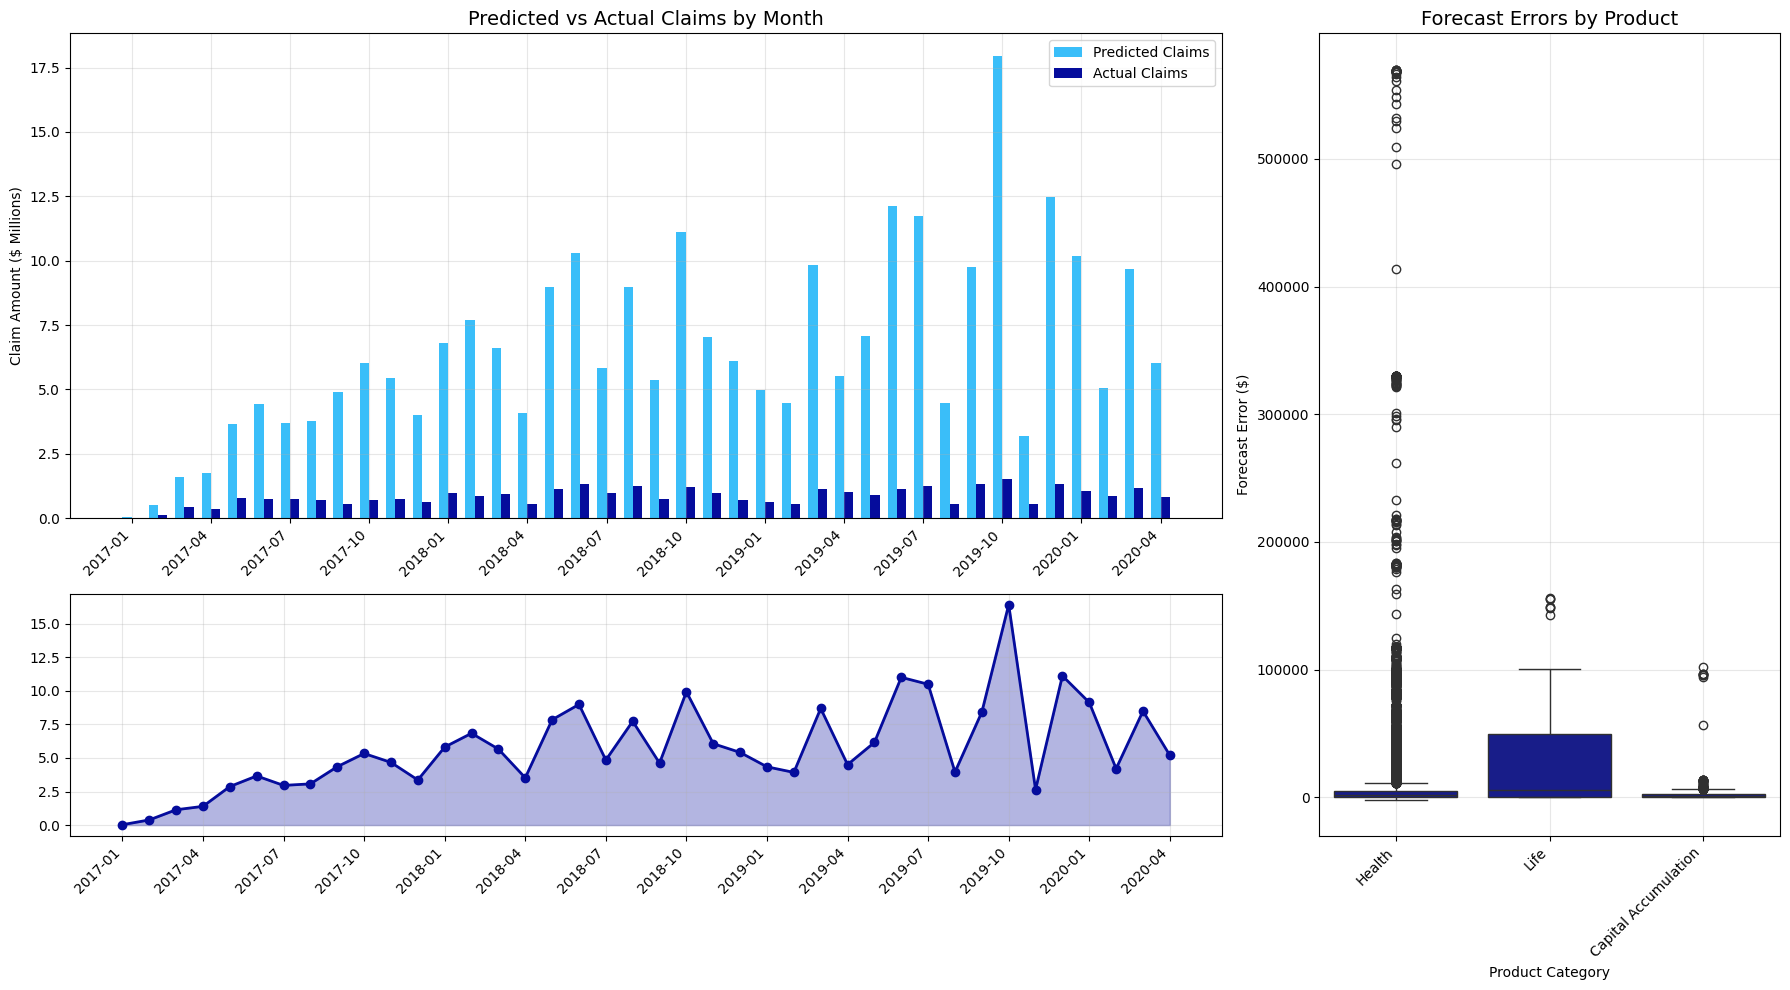

In [42]:
# Calculate forecast error and prepare data
claims_with_forecast = (pd.merge(claims_payments_df, 
                               claims_announcements_df[['ClaimID', 'LastForecastAmount']], 
                               on='ClaimID', how='left')
                       .assign(ForecastError=lambda x: x['LastForecastAmount'] - x['PaymentAmount'],
                              Month=lambda x: pd.to_datetime(x['PaymentDate']).dt.strftime('%Y-%m'))
                       .merge(products_df[['ProductID', 'ProductCategory']], 
                             on='ProductID', how='left'))

# Group by Month for the grouped bar chart
month_comparison = (claims_with_forecast.groupby('Month')
                   .agg({
                       'LastForecastAmount': 'sum',
                       'PaymentAmount': 'sum',
                       'ForecastError': 'sum'
                   })
                   .reset_index())

# Create a figure with a grid layout for three plots
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], width_ratios=[2.5, 1])  # Updated width ratios

# First plot: Predicted vs Actual Claims by Month
ax1 = fig.add_subplot(gs[0, 0])
x = np.arange(len(month_comparison))
width = 0.35

# Convert all monetary values to millions at once
for col in ['LastForecastAmount', 'PaymentAmount', 'ForecastError']:
    month_comparison[f'{col}_millions'] = month_comparison[col] / 1_000_000

bars1 = ax1.bar(x - width/2, month_comparison['LastForecastAmount_millions'], width, 
                label='Predicted Claims', color='#3ABEF9')
bars2 = ax1.bar(x + width/2, month_comparison['PaymentAmount_millions'], width, 
                label='Actual Claims', color='#050C9C')
ax1.set_title('Predicted vs Actual Claims by Month', fontsize=14)
ax1.set_ylabel('Claim Amount ($ Millions)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Second plot: Forecast Error over Time
ax2 = fig.add_subplot(gs[1, 0])
ax2.fill_between(x, month_comparison['ForecastError_millions'], 
                 color='#050C9C', alpha=0.3)
ax2.plot(x, month_comparison['ForecastError_millions'], 
         color='#050C9C', linewidth=2, marker='o')
ax2.grid(True, alpha=0.3)

# Format x-axis for both plots
for ax in [ax1, ax2]:
    ax.set_xticks(x[::3])
    ax.set_xticklabels(month_comparison['Month'][::3], rotation=45, ha='right')

# Third plot: Forecast Errors by Product
ax3 = fig.add_subplot(gs[:, 1])
sns.boxplot(data=claims_with_forecast, x='ProductCategory', y='ForecastError', 
            color='#050C9C', ax=ax3)
ax3.set_title('Forecast Errors by Product', fontsize=14)
ax3.set_xlabel('Product Category')
ax3.set_ylabel('Forecast Error ($)')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**1. Insights from the plots**

| **Feature** | **Evidence** | **Insights** |
|-------------|--------------|--------------|
| **Predicted vs Actual Claims by Month** | Consistent overestimation | Predicted claims are consistently higher than actual claims |
| | Significant spikes | Notable peaks in predictions around late 2019, indicating potential model inaccuracies |
| | Gradual increase | Both predicted and actual claims show a general upward trend over the period |
| **Forecast Error over Time** | Increasing error | Forecast errors grow over time, peaking in late 2019 |
| | Fluctuations | Errors show significant monthly variability, suggesting instability in prediction models |
| **Forecast Errors by Product** | Health insurance variability | Exhibits the highest variability and numerous outliers, indicating prediction challenges |
| | Life insurance error range | Moderate error range with systematic overestimation |
| | Capital accumulation accuracy | Least variability, suggesting more accurate predictions |

**2. Identified problems**

| **Problem** | **Description** |
|-------------|-----------------|
| **Systematic Overestimation** | Predicted claims consistently exceed actual claims, indicating a bias in forecasting models |
| **High Variability in Health Insurance** | Health insurance forecasts show extreme variability and numerous outliers, suggesting model inadequacies |
| **Increasing Forecast Error** | Errors grow over time, particularly in late 2019, indicating potential model drift or external factors not accounted for |

**3. Proposed strategies**

| **Strategy** | **Actions** |
|--------------|-------------|
| **Model Recalibration** | Regularly update prediction algorithms to incorporate recent data and trends<br>Implement historical correction factors to adjust for systematic biases |
| **Outlier Detection and Management** | Develop robust outlier detection systems, particularly for health insurance forecasts<br>Set error thresholds and automatic review triggers to manage extreme deviations |
| **Enhanced Monitoring and Review** | Establish daily error tracking systems and weekly performance reviews<br>Implement monthly model adjustments and quarterly strategy assessments |
| **Product-Specific Forecast Models** | Develop tailored forecasting models for each product category to improve accuracy<br>Incorporate risk-adjusted prediction methods and automated correction mechanisms |

**Implementation priority**

| Priority       | Tasks                        |
|----------------|------------------------------|
| **🔴 High** | - Forecasting model recalibration |
|                | - Monthly review process     |
|                | - Risk reserve adjustment    |
| **🟡 Medium** | - Automated alerts           |
|                | - Tracking metrics           |
|                | - Seasonality adjustments    |
| **🟢 Long-term** | - Strategic planning updates |
|                | - Resource allocation models |
|                | - External factor integration |

# 4. Reserves analysis

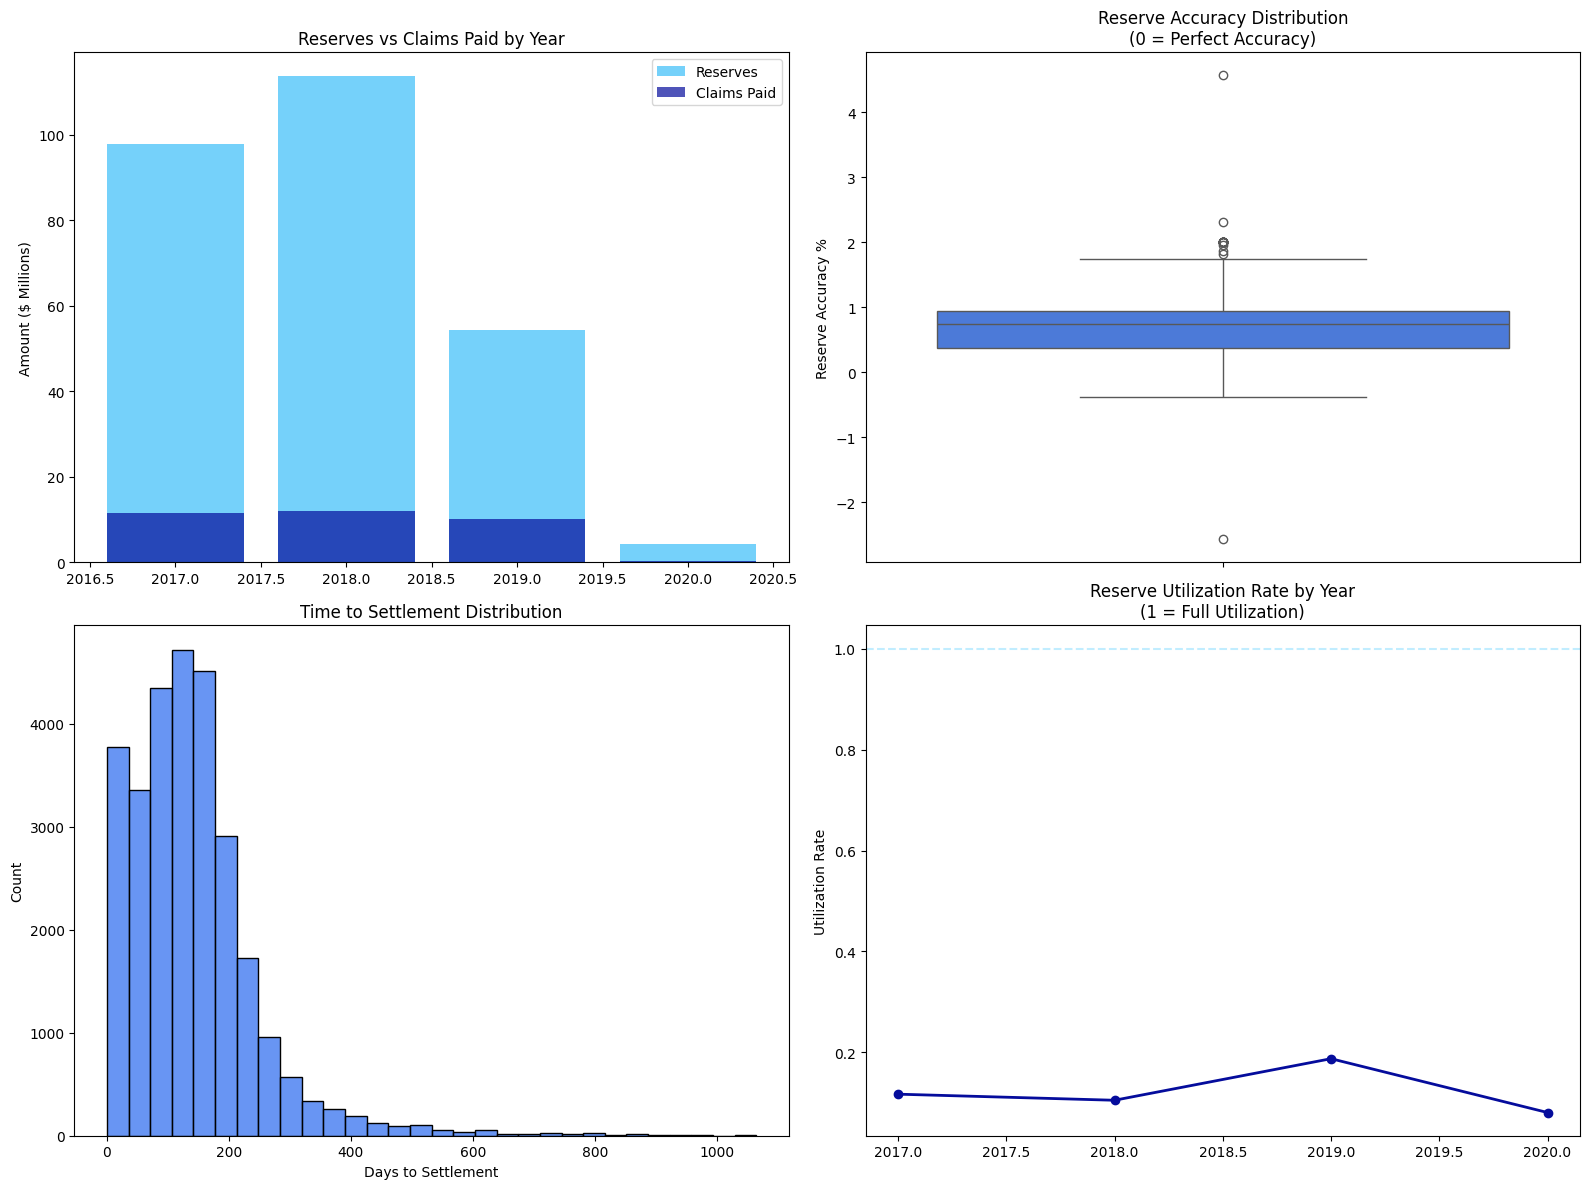

In [101]:
# Calculate reserve metrics
reserve_analysis = (claims_announcements_df.merge(claims_payments_df[['ClaimID', 'PaymentAmount', 'PaymentDate']], 
                                                on='ClaimID', how='left')
                   .assign(
                       AnnouncementYear=lambda x: pd.to_datetime(x['AnnouncementDate']).dt.year,
                       PaymentYear=lambda x: pd.to_datetime(x['PaymentDate']).dt.year,
                       SettlementTime=lambda x: (pd.to_datetime(x['PaymentDate']) - 
                                               pd.to_datetime(x['AnnouncementDate'])).dt.days,
                       ReserveAccuracy=lambda x: (x['LastForecastAmount'] - x['PaymentAmount']) / x['LastForecastAmount']
                   ))

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Reserves vs Claims Paid by Year
yearly_comparison = reserve_analysis.groupby('AnnouncementYear').agg({
    'LastForecastAmount': 'sum',
    'PaymentAmount': 'sum'
}).reset_index()

ax1.bar(yearly_comparison['AnnouncementYear'], 
        yearly_comparison['LastForecastAmount'] / 1e6,
        color='#3ABEF9', alpha=0.7, label='Reserves')
ax1.bar(yearly_comparison['AnnouncementYear'], 
        yearly_comparison['PaymentAmount'] / 1e6,
        color='#050C9C', alpha=0.7, label='Claims Paid')
ax1.set_title('Reserves vs Claims Paid by Year')
ax1.set_ylabel('Amount ($ Millions)')
ax1.legend()

# 2. Reserve Accuracy Distribution
sns.boxplot(data=reserve_analysis, y='ReserveAccuracy', 
            ax=ax2, color='#3572EF')
ax2.set_title('Reserve Accuracy Distribution\n(0 = Perfect Accuracy)')
ax2.set_ylabel('Reserve Accuracy %')

# 3. Settlement Time Distribution
sns.histplot(data=reserve_analysis, x='SettlementTime', 
             bins=30, ax=ax3, color='#3572EF')
ax3.set_title('Time to Settlement Distribution')
ax3.set_xlabel('Days to Settlement')

# 4. Reserve Utilization Rate by Year
yearly_utilization = (reserve_analysis.groupby('AnnouncementYear')
                     .agg({
                         'PaymentAmount': 'sum',
                         'LastForecastAmount': 'sum'
                     })
                     .assign(UtilizationRate=lambda x: x['PaymentAmount'] / x['LastForecastAmount'])
                     .reset_index())

ax4.plot(yearly_utilization['AnnouncementYear'], 
         yearly_utilization['UtilizationRate'],
         color='#050C9C', marker='o', linewidth=2)
ax4.axhline(y=1, color='#A7E6FF', linestyle='--', alpha=0.7)
ax4.set_title('Reserve Utilization Rate by Year\n(1 = Full Utilization)')
ax4.set_ylabel('Utilization Rate')

plt.tight_layout()
plt.show()

**Reserves Analysis Insights**

**1. Reserves vs Claims Paid by Year**
- **Trend Observation**: Reserves consistently exceed claims paid, indicating conservative reserve practices.
- **Yearly Variation**: Significant reserve allocation in 2017 and 2018, with a noticeable drop in 2019.
- **Implication**: Suggests a cautious approach to financial planning, ensuring sufficient reserves to cover potential claims.

**2. Reserve Accuracy Distribution**
- **Accuracy Level**: Most reserve accuracy percentages are close to zero, indicating generally accurate forecasting.
- **Outliers**: Presence of outliers suggests occasional significant deviations from expected reserve accuracy.
- **Implication**: While overall accuracy is good, there are instances of over or under-reserving that need attention.

**3. Time to Settlement Distribution**
- **Settlement Speed**: Majority of claims are settled within 200 days, indicating efficient processing.
- **Long Tail**: Some claims take significantly longer, suggesting complexities in certain cases.
- **Implication**: Efficient settlement processes are in place, but there may be opportunities to streamline complex cases.

**4. Reserve Utilization Rate by Year**
- **Utilization Trend**: Utilization rates are below 1, indicating reserves are not fully utilized.
- **Yearly Fluctuation**: Utilization peaks in 2019, suggesting better alignment between reserves and claims paid.
- **Implication**: Indicates potential for optimizing reserve allocation to better match actual claims.

**Strategic Recommendations**

- **Reserve Optimization**
   + Review reserve allocation strategies to ensure alignment with actual claims trends.
   + Implement regular audits to identify and address outliers in reserve accuracy.

- **Settlement Process Improvement**
   + Analyze long-tail settlement cases to identify bottlenecks and streamline processes.
   + Enhance data collection and analysis to improve forecasting accuracy.

- **Utilization Rate Enhancement**
   + Develop strategies to improve reserve utilization rates, ensuring reserves are effectively used.
   + Consider dynamic reserve allocation models that adjust based on real-time claims data.

These insights and recommendations can help improve financial planning, forecasting accuracy, and operational efficiency in managing reserves and claims.

# 5. Pairplot

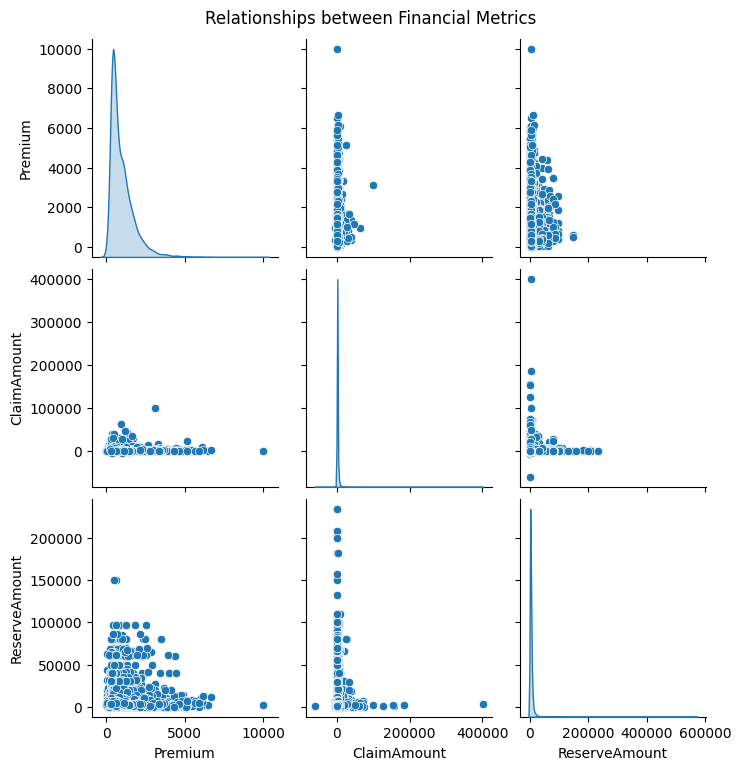

In [ ]:
# Prepare data for pairplot
numeric_data = pd.DataFrame({
    'Premium': policies_df['AnnualizedPolicyPremium'],
    'ClaimAmount': claims_payments_df['PaymentAmount'],
    'ReserveAmount': claims_reserves_df['ProvisionAmount']
})

# Create pairplot
sns.pairplot(numeric_data, diag_kind='kde')
plt.suptitle('Relationships between Financial Metrics', y=1.02)
plt.show()

In this section, we explore the relationships between key financial metrics: Premium, Claim Amount, and Reserve Amount. Understanding these relationships is crucial for effective risk management and strategic financial planning.

**Pairplot Analysis**

The pairplot provides a visual representation of the correlations and distributions among these metrics:

- **Premium vs Claim Amount**: This plot helps identify potential correlations between premium levels and claim amounts, which can indicate risk levels associated with premium pricing strategies.

- **Premium vs Reserve Amount**: By examining this relationship, we can understand how reserve allocations are influenced by premium levels, guiding reserve strategies to ensure adequacy and efficiency.

- **Claim Amount vs Reserve Amount**: This plot offers insights into how reserves are set relative to actual claims, highlighting reserve adequacy and informing adjustments to reserve policies.

**Distribution Patterns**

The diagonal KDE plots within the pairplot reveal the distribution characteristics of each metric, such as skewness or normality. These patterns are essential for assessing the reliability of financial forecasts and planning.

**Strategic Implications**

Understanding the interactions between these financial metrics aids in:

- **Risk Assessment**: Identifying correlations helps assess risk and adjust pricing or reserve strategies accordingly.
- **Financial Planning**: Insights into metric relationships guide strategic decisions in financial planning and resource allocation.

This analysis provides a comprehensive view of how these financial metrics interact, supporting informed decision-making and effective risk management.

# 6. Profitability analysis

## 6.1 Net income through the years

The net income for each quarter is calculated using the following components:

1. **Premiums**: 
   Total annualized policy premiums are aggregated quarterly based on the policy start date.

2. **Claims**: 
   Total payment amounts for claims are aggregated quarterly based on the payment date.

3. **Reserves**: 
   The change in reserve amounts is calculated quarterly based on the provision date. This represents the difference in reserves from one quarter to the next.

4. **Commission**: 
   Commission rates are mapped from the broker's commission scheme, and quarterly commissions are calculated based on the annualized policy premiums and the respective commission rates.

5. **Net Income Formula**:
   - Net Income = Premiums - Claims - ΔReserves - Commission
   - This formula calculates the net income by subtracting claims, changes in reserves, and commissions from the total premiums for each quarter.

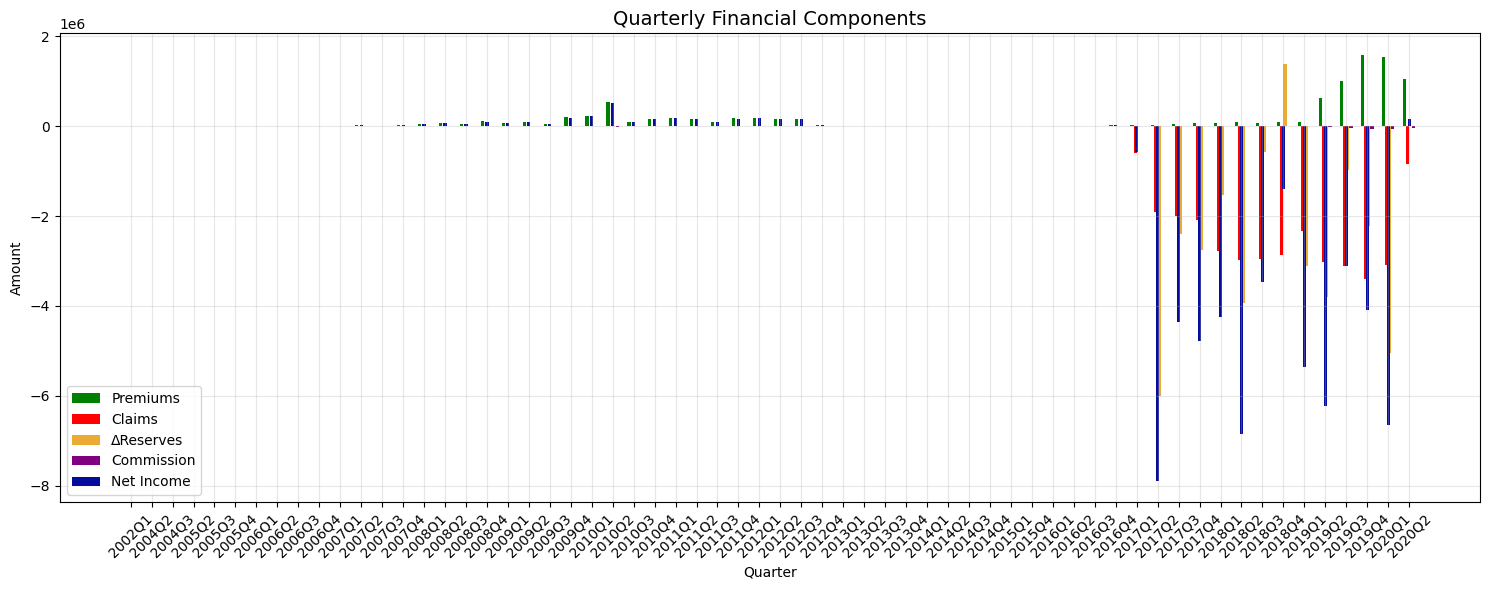

In [63]:
# Convert dates to datetime
policies_df['PolicyStartDate'] = pd.to_datetime(policies_df['PolicyStartDate'])
claims_payments_df['PaymentDate'] = pd.to_datetime(claims_payments_df['PaymentDate'])
claims_reserves_df['ProvisionDate'] = pd.to_datetime(claims_reserves_df['ProvisionDate'])

# Calculate quarterly components
quarterly_premiums = policies_df.groupby(policies_df['PolicyStartDate'].dt.to_period('Q'))['AnnualizedPolicyPremium'].sum()
quarterly_claims = claims_payments_df.groupby(claims_payments_df['PaymentDate'].dt.to_period('Q'))['PaymentAmount'].sum()
quarterly_reserves = claims_reserves_df.groupby(claims_reserves_df['ProvisionDate'].dt.to_period('Q'))['ProvisionAmount'].sum()

# Create commission rate mapping
commission_rates = {
    'Comm-2': 0.02,
    'Comm-3': 0.03,
    'Comm-4': 0.04,
    'Comm-5': 0.05,
    'Comm-6': 0.06,
    'Comm-7': 0.07,
    'Comm-8': 0.08,
    'Comm-9': 0.09,
    'Bonus Based': 0.05,  # Assuming average bonus
    'No Commission': 0
}

# Add commission_rate column to brokers_df
brokers_df['commission_rate'] = brokers_df['CommissionScheme'].map(commission_rates)

# Calculate quarterly commission
policies_with_commission = pd.merge(policies_df, brokers_df[['BrokerID', 'commission_rate']], on='BrokerID', how='left')
quarterly_commission = policies_with_commission.groupby(policies_with_commission['PolicyStartDate'].dt.to_period('Q')).apply(
    lambda x: (x['AnnualizedPolicyPremium'] * x['commission_rate']).sum()
)

# Calculate quarterly net income
quarters = sorted(set(quarterly_premiums.index) | set(quarterly_claims.index) | set(quarterly_reserves.index))
quarterly_data = pd.DataFrame(index=quarters)
quarterly_data['Premiums'] = quarterly_premiums
quarterly_data['Claims'] = quarterly_claims
quarterly_data['Reserves'] = quarterly_reserves.diff()
quarterly_data['Commission'] = quarterly_commission
quarterly_data = quarterly_data.fillna(0)
quarterly_data['Net Income'] = (quarterly_data['Premiums'] - 
                              quarterly_data['Claims'] - 
                              quarterly_data['Reserves'] - 
                              quarterly_data['Commission'])

# Create grouped bar chart
plt.figure(figsize=(15, 6))
x = np.arange(len(quarters))
width = 0.15

plt.bar(x - width*1.5, quarterly_data['Premiums'], width, label='Premiums', color='green')
plt.bar(x - width/2, -quarterly_data['Claims'], width, label='Claims', color='red')
plt.bar(x + width/2, -quarterly_data['Reserves'], width, label='ΔReserves', color='#ECAC34')
plt.bar(x + width*1.5, -quarterly_data['Commission'], width, label='Commission', color='purple')
plt.bar(x, quarterly_data['Net Income'], width, label='Net Income', color='#050C9C')

plt.title('Quarterly Financial Components', fontsize=14)
plt.xlabel('Quarter')
plt.ylabel('Amount')
plt.xticks(x, [str(q) for q in quarters], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

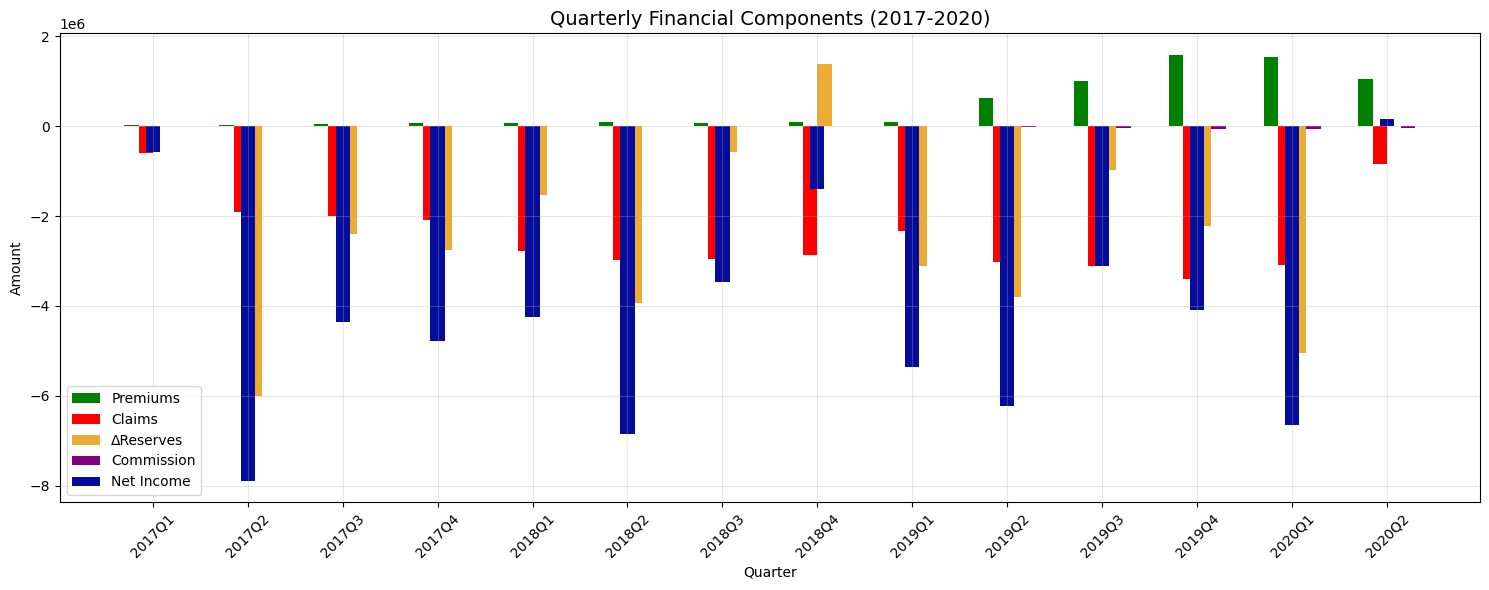


Quarterly Summary (2017-2020):
         Premiums      Claims    Reserves  Commission  Net Income
count       14.00       14.00       14.00       14.00       14.00
mean    455178.66  2426849.25  2212029.13    16888.34 -4200588.07
std     591323.79   856201.31  2081830.16    21962.70  2385192.81
min      18580.34   602749.21 -1372851.25      777.43 -7884882.68
25%      61304.56  2023735.46   670485.06     2276.93 -6009479.38
50%      86247.74  2818734.64  2305100.50     3155.24 -4304489.12
75%     916661.51  3020997.04  3631653.09    34657.82 -3202628.96
max    1589605.73  3402613.83  6009621.07    60140.19   158586.35


In [64]:
# Filter for recent years (2017-2020)
recent_quarters = [q for q in quarters if q.year >= 2017]
recent_data = quarterly_data.loc[recent_quarters]

# Create grouped bar chart for recent years
plt.figure(figsize=(15, 6))
x = np.arange(len(recent_quarters))
width = 0.15

plt.bar(x - width*1.5, recent_data['Premiums'], width, label='Premiums', color='green')
plt.bar(x - width/2, -recent_data['Claims'], width, label='Claims', color='red')
plt.bar(x + width/2, -recent_data['Reserves'], width, label='ΔReserves', color='#ECAC34')
plt.bar(x + width*1.5, -recent_data['Commission'], width, label='Commission', color='purple')
plt.bar(x, recent_data['Net Income'], width, label='Net Income', color='#050C9C')

plt.title('Quarterly Financial Components (2017-2020)', fontsize=14)
plt.xlabel('Quarter')
plt.ylabel('Amount')
plt.xticks(x, [str(q) for q in recent_quarters], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics for recent years
print("\nQuarterly Summary (2017-2020):")
print(recent_data.describe().round(2))

As seen in the financial timeline, net income was consistently negative, reflecting structural pressure from claims and reserves. But by Q2 2020, we finally saw a small but meaningful positive net income.

-> This suggests we’re turning a corner - but the gains are fragile. Sustaining profitability depends on:
- Continuing to grow premium volume,
- Tightening claim controls, especially in Health and Life products,
- And optimizing our reserve management strategies.


## 6.2 Net income by product

C:\Users\Dell\AppData\Local\Temp\ipykernel_12672\899781733.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'ProductCategory']).apply(


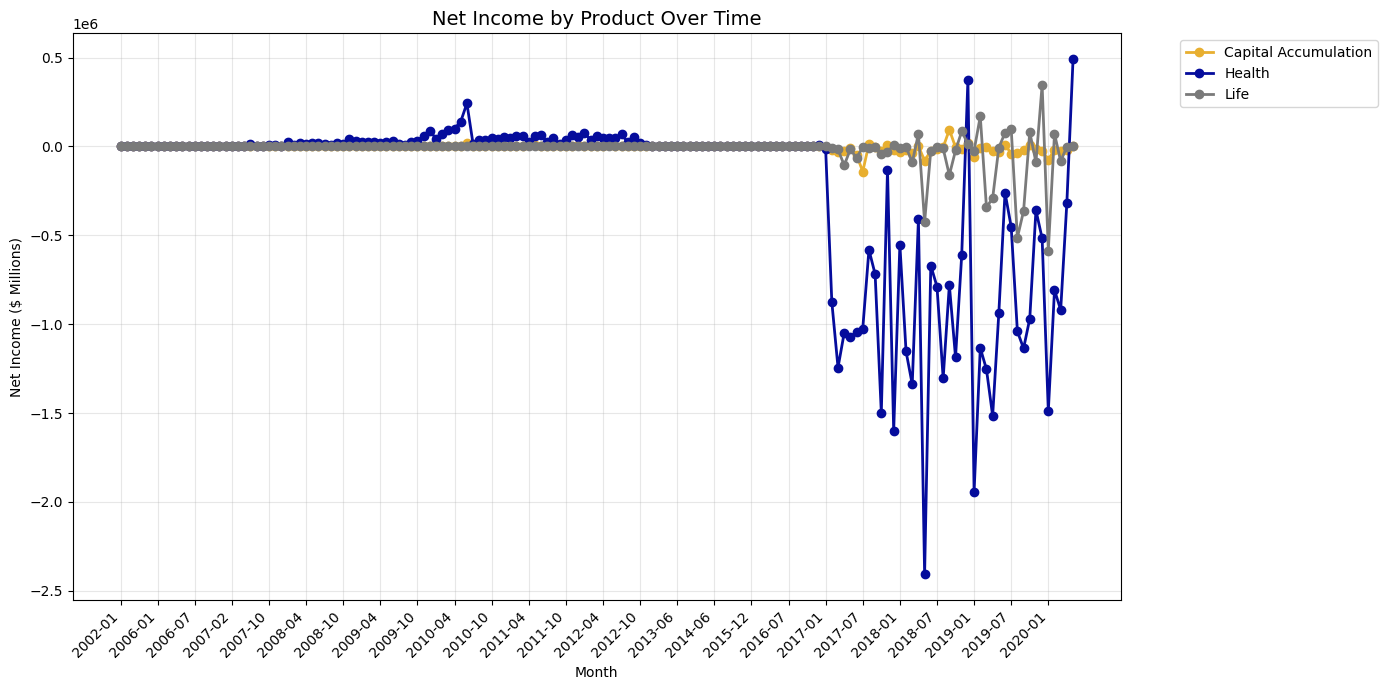

In [65]:
# Convert dates to datetime
policies_df['PolicyStartDate'] = pd.to_datetime(policies_df['PolicyStartDate'])
claims_payments_df['PaymentDate'] = pd.to_datetime(claims_payments_df['PaymentDate'])
claims_reserves_df['ProvisionDate'] = pd.to_datetime(claims_reserves_df['ProvisionDate'])

# Drop ProductCategory if it already exists to avoid merge conflicts
for df in [policies_df, claims_payments_df, claims_reserves_df]:
    if 'ProductCategory' in df.columns:
        df.drop(columns=['ProductCategory'], inplace=True)

# Merge ProductCategory information
policies_with_category = policies_df.merge(products_df[['ProductID', 'ProductCategory']], on='ProductID', how='left')
claims_payments_with_category = claims_payments_df.merge(products_df[['ProductID', 'ProductCategory']], on='ProductID', how='left')
claims_reserves_with_category = claims_reserves_df.merge(products_df[['ProductID', 'ProductCategory']], on='ProductID', how='left')

# Calculate monthly components by product
monthly_premiums = policies_with_category.groupby([policies_with_category['PolicyStartDate'].dt.to_period('M'), 
                                                 'ProductCategory'])['AnnualizedPolicyPremium'].sum()
monthly_claims = claims_payments_with_category.groupby([claims_payments_with_category['PaymentDate'].dt.to_period('M'), 
                                                      'ProductCategory'])['PaymentAmount'].sum()
monthly_reserves = claims_reserves_with_category.groupby([claims_reserves_with_category['ProvisionDate'].dt.to_period('M'), 
                                                        'ProductCategory'])['ProvisionAmount'].sum()

# Create commission rate mapping
commission_rates = {
    'Comm-2': 0.02, 'Comm-3': 0.03, 'Comm-4': 0.04, 'Comm-5': 0.05,
    'Comm-6': 0.06, 'Comm-7': 0.07, 'Comm-8': 0.08, 'Comm-9': 0.09,
    'Bonus Based': 0.05, 'No Commission': 0
}

# Calculate monthly commission by product
brokers_df['commission_rate'] = brokers_df['CommissionScheme'].map(commission_rates)
policies_with_commission = policies_with_category.merge(brokers_df[['BrokerID', 'commission_rate']], on='BrokerID', how='left')
monthly_commission = policies_with_commission.groupby([policies_with_commission['PolicyStartDate'].dt.to_period('M'),
                                                     'ProductCategory']).apply(
    lambda x: (x['AnnualizedPolicyPremium'] * x['commission_rate']).sum()
)

# Calculate monthly net income by product
months_products = pd.MultiIndex.from_product([
    sorted(set(monthly_premiums.index.get_level_values(0)) | 
          set(monthly_claims.index.get_level_values(0)) | 
          set(monthly_reserves.index.get_level_values(0))),
    ['Capital Accumulation', 'Health', 'Life']
], names=['Month', 'ProductCategory'])

monthly_data = pd.DataFrame(index=months_products)
monthly_data['Premiums'] = monthly_premiums
monthly_data['Claims'] = monthly_claims
monthly_data['Reserves'] = monthly_reserves.groupby('ProductCategory').diff()
monthly_data['Commission'] = monthly_commission
monthly_data = monthly_data.fillna(0)

monthly_data['Net Income'] = (monthly_data['Premiums'] - 
                            monthly_data['Claims'] - 
                            monthly_data['Reserves'] - 
                            monthly_data['Commission'])

# Create line plot
plt.figure(figsize=(14, 7))

# Define colors for each product
colors = {'Capital Accumulation': '#E8AF30',
          'Health': '#050C9C',
          'Life': '#7A7A7A'}

# Plot line for each product
for product, color in colors.items():
    product_data = monthly_data.xs(product, level='ProductCategory')
    plt.plot(range(len(product_data)), product_data['Net Income'], 
            label=product, marker='o', linewidth=2, color=color)

plt.title('Net Income by Product Over Time', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Net Income ($ Millions)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Format x-axis
plt.xticks(range(0, len(monthly_data.index.get_level_values('Month').unique()), 6),
           [str(m) for m in monthly_data.index.get_level_values('Month').unique()[::6]],
           rotation=45, ha='right')

plt.tight_layout()
plt.show()

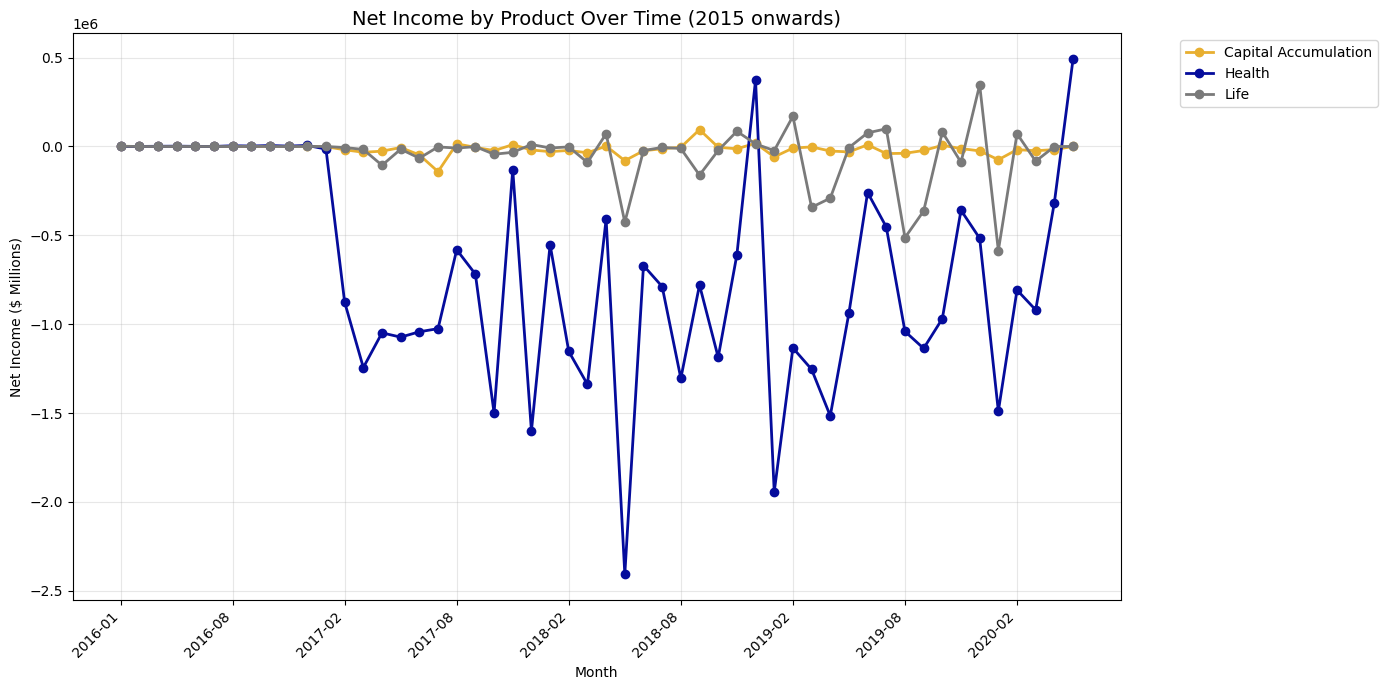

In [ ]:
# Filter data for recent years (e.g., from 2015 onwards)
recent_months = monthly_data.index.get_level_values('Month') >= '2016-01'
recent_data = monthly_data[recent_months]

# Create line plot for recent data
plt.figure(figsize=(14, 7))

# Define colors for each product
colors = {'Capital Accumulation': '#E8AF30',
          'Health': '#050C9C',
          'Life': '#7A7A7A'}

# Plot line for each product
for product, color in colors.items():
    product_data = recent_data.xs(product, level='ProductCategory')
    plt.plot(range(len(product_data)), product_data['Net Income'], 
            label=product, marker='o', linewidth=2, color=color)

plt.title('Net Income by Product Over Time (2015 onwards)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Net Income ($ Millions)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Format x-axis
plt.xticks(range(0, len(recent_data.index.get_level_values('Month').unique()), 6),
           [str(m) for m in recent_data.index.get_level_values('Month').unique()[::6]],
           rotation=45, ha='right')
plt.tight_layout()
plt.show()

From 2015 to 2020, net income was dominated by instability in the Health segment, with heavy losses and rare surpluses. Life Insurance hovered near break-even, offering stability but little gain. Capital Accumulation was steady and risk-free, suggesting it's a strong candidate for expansion. Our 2020 positive shift in Health might mark the beginning of a financial rebound - if we stay focused on operational efficiency and smarter underwriting.